In [2]:
# for better results take the image straight and include all the grid and not much of anthing else
#https://stackoverflow.com/questions/48954246/find-sudoku-grid-using-opencv-and-python
import cv2
import numpy as np


filter = False


file_path = 'sample00.jpg'
img = cv2.imread(file_path)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 1)
kernel = np.ones((5,5),np.uint8)
edges = cv2.erode(edges,kernel,iterations = 1)
cv2.imwrite('canny.jpg',edges)

lines = cv2.HoughLines(edges,1,np.pi/180,150)

if not lines.any():
    print('No lines were found')
    exit()

if filter:
    rho_threshold = 15
    theta_threshold = 0.1

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

filtered_lines = []

if filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    #cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('hough.jpg',img)

number of Hough lines: 33


True

## Get lines intersections

[1554, 1892, 2024, 2744, 1892, 1848, 1680, 1892, 1640, 1806, 1521, 1848, 1680, 1482, 1763, 1368, 1640, 1258, 1722, 1560, 1600, 1600, 1806, 2322, 1521, 1482, 1722, 1482, 1368, 1640, 1404, 1482, 1764, 1365, 1480, 1640, 1258, 1365, 1599, 1254, 1520, 1184, 1640, 1443, 1050, 1520, 1330, 1443, 1258, 1368, 1254, 1330, 1085, 1520, 1221, 1480, 1152, 1330, 1147, 1258, 1015, 1152, 1050, 1517, 952, 1400, 980, 1254, 825, 1116, 1050, 952, 884, 1209, 875, 1178, 713, 1050, 1050, 1015, 952, 918, 936, 768, 736, 999, 1085, 1332, 1599, 1760, 2016, 2392, 2736]
Found 93 areas of median 1400.


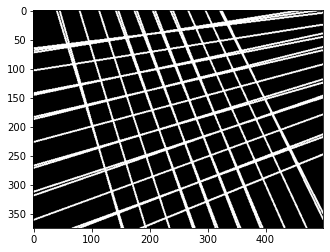

In [85]:
import cv2
import numpy as np
from __future__ import division 
from matplotlib import pyplot as plt


img = cv2.imread(file_path)
img2 = np.zeros(img.shape, dtype=np.uint8)
im_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)


def lineF(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


def getLine(line):
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    L1 = lineF([x1, y1], [x2, y2])
    return L1, x1, y1, x2, y2

import math
 
def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang
 
    
toleranceAng = 20
for i in range(0,len(filtered_lines)-1):
    
    L1,x1,y1, x2, y2 = getLine(filtered_lines[i])
    
    for j in range(1,len(filtered_lines)):
        L2,x3,y3, x4, y4 = getLine(filtered_lines[j])
        R = intersection(L1, L2)
        if R:
            angIs = angle3pt((x1,y1), R, (x3,y3))
            if (angIs >= 90-toleranceAng and angIs <= 90+toleranceAng) or (angIs >= 270-toleranceAng and angIs <= 270+toleranceAng):
                R = (int(R[0]), int(R[1]))
                # Radius of circle
                radius = 2
                # white color in BGR
                color = (255, 255, 255)
                # Line thickness of 2 px
                thickness = 2  
                # Using cv2.circle() method
                # Draw a circle with blue line borders of thickness of 2 px
                #cv2.circle(img2, R, radius, color, thickness)
                cv2.line(img,(x1,y1),(x2,y2),color,2)
                cv2.line(img,(x3,y3),(x4,y4),color,2)
                                

                
# Displaying the image 
#window_name = 'Image' 
#cv2.imshow(window_name, img) 
cv2.imwrite('inters.jpg',img2)

ret,thresh1 = cv2.threshold(img,254,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh1[:,:,1], cmap = 'Greys')

cnts = cv2.findContours(thresh1[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
toleranceArea = 0.6
if img.shape[0]>img.shape[1]:
    maxSize = (img.shape[1]/9)*(img.shape[1]/9)*(1+toleranceArea)
    minSize = (img.shape[1]/9)*(img.shape[1]/9)*(1-toleranceArea)
else:
    maxSize = (img.shape[0]/9)*(img.shape[0]/9)*(1+toleranceArea)
    minSize = (img.shape[0]/9)*(img.shape[0]/9)*(1-toleranceArea)
    
# Iterate thorugh contours and filter for ROI
image_number = 0
toleranceIs = 0.7
allAreas = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    dims = sorted([w,h])
    ratioIs = dims[0]/dims[1]
    if w*h>minSize and w*h<maxSize and (ratioIs > toleranceIs):
        allAreas.append(w*h)
        ROI = img[y:y+h, x:x+w]
        #cv2.imwrite("./rois/ROI_{}.png".format(image_number), ROI)
        image_number += 1
    

from statistics import median

print(allAreas)
print('Found {} areas of median {}.'.format(len(allAreas), median(allAreas)))


In [101]:
# Function to find the cross over point  
# (the point before which elements are  
# smaller than or equal to x and after  
# which greater than x)  
def findCrossOver(arr, low, high, x) :  
  
    # Base cases  
    if (arr[high] <= x) : # x is greater than all  
        return high 
          
    if (arr[low] > x) : # x is smaller than all  
        return low  
      
    # Find the middle point  
    mid = (low + high) // 2 # low + (high - low)// 2  
      
    # If x is same as middle element,  
    # then return mid  
    if (arr[mid] <= x and arr[mid + 1] > x) : 
        return mid  
      
    # If x is greater than arr[mid], then  
    # either arr[mid + 1] is ceiling of x  
    # or ceiling lies in arr[mid+1...high]  
    if(arr[mid] < x) : 
        return findCrossOver(arr, mid + 1, high, x) 
      
    return findCrossOver(arr, low, mid - 1, x) 
  
# This function prints k closest elements to x  
# in arr[]. n is the number of elements in arr[]  
def printKclosest(arr, x, k, n) : 
      
    # Find the crossover point  
    l = findCrossOver(arr, 0, n - 1, x) 
    r = l + 1 # Right index to search  
    count = 0 # To keep track of count of  
              # elements already printed  
  
    # If x is present in arr[], then reduce  
    # left index. Assumption: all elements  
    # in arr[] are distinct  
    if (arr[l] == x) : 
        l -= 1
  
    res = []
    # Compare elements on left and right of crossover  
    # point to find the k closest elements  
    while (l >= 0 and r < n and count < k) : 
          
        if (x - arr[l] < arr[r] - x) : 
            res.append(arr[l])
            #print(arr[l], end = " ")  
            l -= 1
        else : 
            res.append(arr[r])
            #print(arr[r], end = " ")  
            r += 1
        count += 1
  
    # If there are no more elements on right  
    # side, then print left elements  
    while (count < k and l >= 0) : 
        res.append(arr[l])
        #print(arr[l], end = " ") 
        l -= 1
        count += 1
  
    # If there are no more elements on left  
    # side, then print right elements  
    while (count < k and r < n) :  
        res.append(arr[r])
        #print(arr[r], end = " ") 
        r += 1
        count += 1
    return(res)
        
n = len(allAreas) 
x = median(allAreas)
k = 81
 
#allOK = printKclosest(allAreas, x, k, n) 


while True:
    allOK = printKclosest(allAreas, x, k, n)
    image_number = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h in allOK:
            ROI = img[y:y+h, x:x+w]
            image_number += 1
            
    if image_number > 82:
        k=k-1
    else:
        image_number = 0
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            if w*h in allOK:
                ROI = img[y:y+h, x:x+w]
                cv2.imwrite("./rois/ROI_{}.png".format(image_number), ROI)
                image_number += 1
        break



[['0', '0', '0', '7', '0', '0', '0', '8', '0'], ['0', '9', '0', '0', '0', '3', '1', '0', '0'], ['0', '0', '6', '8', '0', '5', '0', '7', '0'], ['0', '2', '0', '6', '0', '0', '0', '4', '9'], ['0', '0', '0', '2', '0', '0', '0', '5', '0'], ['0', '0', '8', '0', '4', '0', '0', '0', '7'], ['0', '0', '0', '9', '0', '0', '0', '3', '0'], ['3', '7', '0', '0', '0', '0', '0', '0', '6'], ['1', '0', '5', '0', '0', '4', '0', '0', '0']]
image1.dat


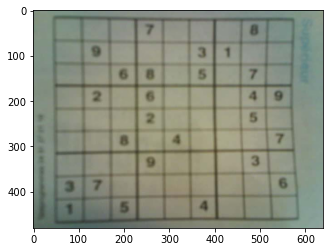

In [125]:
import os
labelsDataDir = 'D:\\repos\\sudokuSolver_py\\allImgsLabelledDB\\'
npyDataDir = 'D:\\repos\\sudokuSolver_py\\rawImg\\'

allNpys = []
for file in os.listdir(npyDataDir):
    if file.endswith(".npy"):
        allNpys.append(file)

allLabels = []
names = []
for file in os.listdir(labelsDataDir):
    if file.endswith(".dat"):
        with open(labelsDataDir+file) as f:
            allLabels.append([line.split()[0:9] for line in f])
            
            names.append(file)
print(allLabels[0][2:])
print(names[0])

from PIL import Image
# load the image
image = Image.open(npyDataDir +  names[0].replace('.dat', '.jpg'))
# convert image to numpy array
data = np.asarray(image)
plt.imshow(data)